In [2]:
import requests
import sys
sys.path.append('/home/greg/GitHub/')
#import edi_pyagnostics.edi_changes as dia
import pyEDIutils.edi_changes as dia
import pandas as pd
import numpy as np

## Get recent changes

In [4]:
#curl -i -X GET "https://pasta.lternet.edu/package/changes/eml?fromDate=2017-02-01T12:00:00&toDate=2020-01-28&scope=knb-lter-jrn"
# This is the "List recent changes" call  https://pastaplus-core.readthedocs.io/en/latest/doc_tree/pasta_api/data_package_manager_api.html#list-recent-changes
params = (
    ('fromDate', '2019-01-01'),
    #('toDate', '2019-01-01'),
    ('scope', 'knb-lter-jrn'))#,
#    ('environment', 'production'))

response = requests.get('https://pasta.lternet.edu/package/changes/eml', params=params)

In [5]:
# Response = long XML string that can be parsed with elementtree, beautifulsoup, etc
response.text[0:300] # now parse this with 

'<dataPackageChanges>\n  <dataPackage>\n    <packageId>knb-lter-jrn.210385003.12</packageId>\n    <scope>knb-lter-jrn</scope>\n    <identifier>210385003</identifier>\n    <revision>12</revision>\n    <principal>uid=JRN,o=LTER,dc=ecoinformatics,dc=org</principal>\n    <doi>doi:10.6073/pasta/d267dbfcacf70475e'

In [5]:
# Parse the xml into an "ElementTree" object called root
import xml.etree.ElementTree as ET

tree_old = ET.parse('edi_requests/knb-lter-jrn_20150417-20181231.xml')
root_old = tree_old.getroot()

root = ET.fromstring(response.text)

In [6]:
# Number of elements (EDI changes) in root
print(len(root_old))
len(root)

287


947

## Parse the data sent from EDI

In [8]:
# Create a dataframe from the entire record in root
df_old = pd.DataFrame({'date':[date.text for date in root_old.iter('date')],
                   'pkgid':[int(ID.text) for ID in root_old.iter('identifier')],
                   'action':[sm.text for sm in root_old.iter('serviceMethod')]}
                   )

# Create a dataframe from the entire record in root
df = pd.DataFrame({'date':[date.text for date in root.iter('date')],
                   'pkgid':[int(ID.text) for ID in root.iter('identifier')],
                   'action':[sm.text for sm in root.iter('serviceMethod')]}
                   )
df = pd.concat([df_old,df])

print(len(df))

print(df.head())

df.tail()

1234
                      date       pkgid             action
0  2015-04-17T14:42:05.936  2100011003  createDataPackage
1  2015-04-17T15:43:26.172   210120002  createDataPackage
2  2015-04-17T15:43:26.771  2100392001  createDataPackage
3  2015-04-17T15:43:41.508  2100169002  createDataPackage
4   2015-04-17T15:43:45.55  2100010001  createDataPackage


,date,pkgid,action
942,2020-02-07T15:40:07.774,210338006,updateDataPackage
943,2020-02-07T16:18:52.15,210338004,updateDataPackage
944,2020-02-07T17:30:31.664,210338002,updateDataPackage
945,2020-02-09T20:29:34.542,210351002,updateDataPackage
946,2020-02-09T20:51:57.085,210351001,updateDataPackage


In [10]:
# Make the index the date
df.index = pd.to_datetime(df['date'])#, format='%Y-%b-%dT%H:%M:%S.%f')

In [11]:
# Add columns - number of updates and creates, + extracted study id
df['n_update'] = 0
df['n_create'] = 0
df['n_delete'] = 0
df['n_tot'] = 0
df['studyid'] = df.pkgid.astype(str).str[-6:-3] #convert to str, studyid excludes mistaken 0

In [12]:
# Fill in number of updates or create for each record
df.loc[df.action=='updateDataPackage','n_update'] = 1
df.loc[df.action=='createDataPackage','n_create'] = 1
df.loc[df.action=='deleteDataPackage','n_delete'] = 1
# for totals, create = +1, delete = -1
df.loc[df.action=='createDataPackage','n_tot'] = 1
df.loc[df.action=='deleteDataPackage','n_tot'] = -1
df.head()

,date,pkgid,action,n_update,n_create,n_delete,n_tot,studyid
date,,,,,,,,
2015-04-17 14:42:05.936,2015-04-17T14:42:05.936,2100011003,createDataPackage,0,1,0,1,011
2015-04-17 15:43:26.172,2015-04-17T15:43:26.172,210120002,createDataPackage,0,1,0,1,120
2015-04-17 15:43:26.771,2015-04-17T15:43:26.771,2100392001,createDataPackage,0,1,0,1,392
2015-04-17 15:43:41.508,2015-04-17T15:43:41.508,2100169002,createDataPackage,0,1,0,1,169
2015-04-17 15:43:45.550,2015-04-17T15:43:45.55,2100010001,createDataPackage,0,1,0,1,010


In [13]:
# There are duplicate deletions (9 at last count)
df_dd = df.drop_duplicates()
n_dupdeletes = df.shape[0] - df_dd.shape[0]
df = df_dd
# Count deleted packages
deleted_pkgs = df.loc[df.action=='deleteDataPackage','pkgid']
print(df.shape)
deleted_pkgs

(1225, 8)


date
2018-09-04 16:19:30.652    2100001002
2018-09-04 16:22:44.016    2100002001
2018-09-04 16:22:59.365    2100007001
2018-09-04 16:23:13.850    2100010001
2018-09-04 16:23:31.433    2100011001
2018-09-04 16:23:43.748    2100011003
2018-09-04 16:23:53.312    2100011004
2018-09-04 16:24:03.080    2100011005
2018-09-04 16:24:13.741    2100086001
2018-09-04 16:24:25.430    2100086002
2018-09-04 16:24:34.326    2100086003
2018-09-04 16:24:49.081    2100086004
2018-09-04 16:24:59.973    2100086005
2018-09-04 16:25:08.555    2100086006
2018-09-04 16:25:17.583    2100086007
2018-09-04 16:25:31.933    2100086008
2018-09-04 16:25:41.114    2100086009
2018-09-04 16:25:53.153    2100119001
2018-09-04 16:26:01.647    2100121004
2018-09-04 16:26:12.163    2100121005
2018-09-04 16:26:21.306    2100126001
2018-09-04 16:26:30.647    2100126003
2018-09-04 16:26:40.208    2100127001
2018-09-04 16:26:48.769    2100169001
2018-09-04 16:26:59.328    2100169002
2018-09-04 16:27:08.714    2100278001
2018-09

## Create daily data file

In [14]:
# Resample with sum to get the daily number of updates/creates
dEDI = df.loc[:,['n_update', 'n_create', 'n_tot']].resample('D').sum()
dEDI.head()

,n_update,n_create,n_tot
date,,,
2015-04-17,0,20,20
2015-04-18,0,1,1
2015-04-19,0,0,0
2015-04-20,0,11,11
2015-04-21,0,2,2


## Activity 2016 -  Sept 2018


In [15]:
startdt = "2014-01-01"
enddt = "2018-09-05"

rdEDI_early = df.loc[np.logical_and(df.index > startdt, df.index < enddt), ['n_update', 'n_create', 'n_tot']].resample('D').sum()
rdEDI_early.head()

,n_update,n_create,n_tot
date,,,
2015-04-17,0,20,20
2015-04-18,0,1,1
2015-04-19,0,0,0
2015-04-20,0,11,11
2015-04-21,0,2,2


In [16]:
import matplotlib
import matplotlib.pyplot as plt
# Figure config
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [17]:
# Get a datestamp for saving figures
import datetime
now = datetime.datetime.now().strftime("%Y%m%d")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


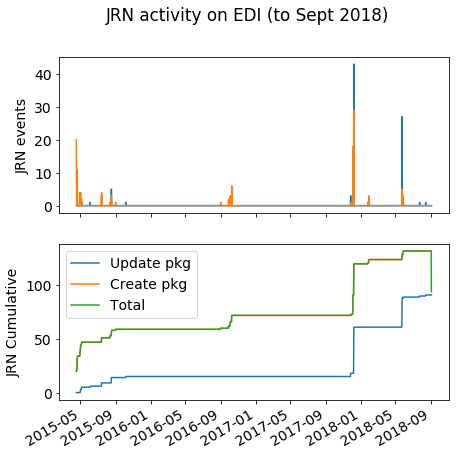

In [18]:
# All time plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(rdEDI_early.index, rdEDI_early.n_update, label='Update pkg')
ax[0].plot(rdEDI_early.index, rdEDI_early.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(rdEDI_early.index, rdEDI_early.n_update.cumsum(), label='Update pkg')
ax[1].plot(rdEDI_early.index, rdEDI_early.n_create.cumsum(), label='Create pkg')
ax[1].plot(rdEDI_early.index, rdEDI_early.n_tot.cumsum(), label='Total')

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (to Sept 2018)')
plt.legend()

import os
#fig.savefig(os.path.expanduser("~/GD_gmaurer.jrn.lter/IM_diagnostics/JRN_EDI_all_{0}.png".format(now)),
#            dpi=150)

### Total number of packages

In [19]:
print(rdEDI_early.n_tot.sum())
rdEDI_early.n_update.sum()

94


91

## Activity since  Sept 2018


In [20]:
# This is after the LTER probabtion shock and after some big 
# delete operations on EDI
rdEDI_late = df.loc[df.index > enddt,
                         ['n_update', 'n_create', 'n_tot']].resample('D').sum()
rdEDI_late.head()

,n_update,n_create,n_tot
date,,,
2018-10-10,0,1,1
2018-10-11,0,1,1
2018-10-12,0,4,4
2018-10-13,0,0,0
2018-10-14,0,0,0


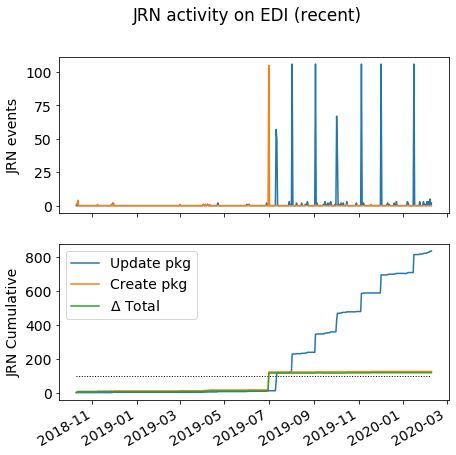

In [21]:
# Recent plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(rdEDI_late.index, rdEDI_late.n_update, label='Update pkg')
ax[0].plot(rdEDI_late.index, rdEDI_late.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(rdEDI_late.index, rdEDI_late.n_update.cumsum(), label='Update pkg')
ax[1].plot(rdEDI_late.index, rdEDI_late.n_create.cumsum(), label='Create pkg')
ax[1].plot(rdEDI_late.index, rdEDI_late.n_tot.cumsum(), label='$\Delta$ Total')
ax[1].hlines(y=100, xmin=rdEDI_late.index.min(), xmax=rdEDI_late.index.max(), ls=':', lw=1)

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (recent)')
plt.legend()

In [22]:
print(rdEDI_late.n_tot.sum())
rdEDI_late.n_update.sum()

117


833

### Late/early stats

In [23]:
print(rdEDI_late.n_tot.sum()/rdEDI_early.n_tot.sum())
print(rdEDI_late.n_update.sum()/rdEDI_early.n_update.sum())

1.2446808510638299
9.153846153846153


## Activity since  Sept 2018, NOMET


In [24]:
# This is after the LTER probabtion shock and after some big 
# delete operations on EDI
rdEDI_lateNM = df.loc[np.logical_and(df.index > enddt, df.studyid!='437'),
                         ['n_update', 'n_create', 'n_tot']].resample('D').sum()
rdEDI_lateNM.head()

,n_update,n_create,n_tot
date,,,
2018-10-10,0,1,1
2018-10-11,0,1,1
2018-10-12,0,4,4
2018-10-13,0,0,0
2018-10-14,0,0,0


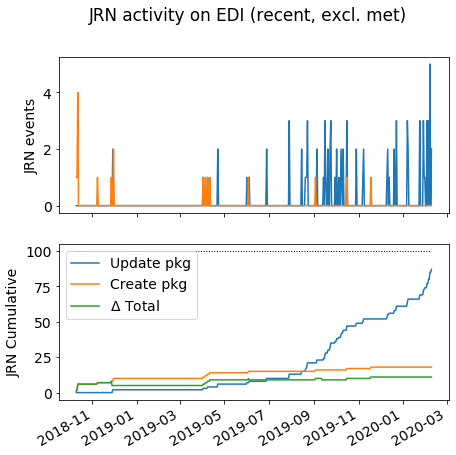

In [25]:
# Recent plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(rdEDI_lateNM.index, rdEDI_lateNM.n_update, label='Update pkg')
ax[0].plot(rdEDI_lateNM.index, rdEDI_lateNM.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(rdEDI_lateNM.index, rdEDI_lateNM.n_update.cumsum(), label='Update pkg')
ax[1].plot(rdEDI_lateNM.index, rdEDI_lateNM.n_create.cumsum(), label='Create pkg')
ax[1].plot(rdEDI_lateNM.index, rdEDI_lateNM.n_tot.cumsum(), label='$\Delta$ Total')
ax[1].hlines(y=100, xmin=rdEDI_lateNM.index.min(), xmax=rdEDI_lateNM.index.max(), ls=':', lw=1)

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (recent, excl. met)')
plt.legend()

In [26]:
print(rdEDI_lateNM.n_tot.sum())
rdEDI_lateNM.n_update.sum()

11


87

### Late/early stats

In [27]:
print(rdEDI_lateNM.n_tot.sum()/rdEDI_early.n_tot.sum())
print(rdEDI_lateNM.n_update.sum()/rdEDI_early.n_update.sum())

0.11702127659574468
0.9560439560439561


## New fig

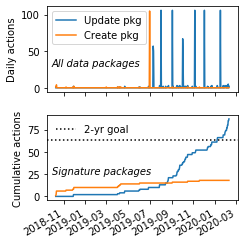

In [97]:
# Recent plot:
# Figure config
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(3.5, 3.5), sharex=True)

ax[0].plot(rdEDI_late.index, rdEDI_late.n_update, label='Update pkg')
ax[0].plot(rdEDI_late.index, rdEDI_late.n_create, label='Create pkg')
ax[0].set_ylabel('Daily actions')
ax[0].text(.025, .3, 'All data packages', transform=ax[0].transAxes, style='italic')
ax[0].legend(loc="upper left")

ax[1].plot(rdEDI_lateNM.index, rdEDI_lateNM.n_update.cumsum())
ax[1].plot(rdEDI_lateNM.index, rdEDI_lateNM.n_create.cumsum())
#ax[1].plot(rdEDI_lateNM.index, rdEDI_lateNM.n_tot.cumsum(), label='$\Delta$ Total')
ax[1].axhline(y=63, xmin=0, xmax=1, ls=':', lw=1.5, color='k',
             label='2-yr goal')
ax[1].text(.025, .3, 'Signature packages', transform=ax[1].transAxes, style='italic')

plt.ylabel('Cumulative actions')
fig.autofmt_xdate()
#plt.suptitle('JRN activity on EDI, LTER-VII')
ax[1].legend(loc="upper left", framealpha=0)

plt.tight_layout()
fig.savefig(os.path.expanduser(
    "~/GD_gmaurer.jrn.lter/IM_figures/JRN_EDI_2020proposal.png".format(now)),
            dpi=300)